In [1]:
import gymnasium as gym
import torch as th
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# import EvnOneStock
import EvnSingleStock

import pandas as pd
# import numpy as np
# from datetime import datetime

In [2]:
# 1. 定义自定义特征提取器 和 简单的 mlp_extractor 自定义
class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        
        self.layers = nn.Sequential(
            nn.Linear(n_input_channels, 128),
            nn.ReLU(),
            nn.Linear(128, features_dim),
            nn.ReLU(),
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.layers(observations)

# 2. 配置 policy_kwargs
policy_kwargs = dict(
    # PPO_v2_001
    features_extractor_class=CustomCombinedExtractor,
    features_extractor_kwargs=dict(features_dim=256),
    # 自定义 mlp_extractor 就在这里：
    # net_arch=dict(
    #     pi=[128, 64],  # 策略网络 (Actor) 的隐藏层：256 -> 128 -> 64
    #     vf=[64, 64]    # 价值网络 (Critic) 的隐藏层：256 -> 64 -> 64
    # )
)

In [3]:
# 3. 创建模型
stock_code = "600118.SH"
stock_daily_pd = pd.read_csv(f"./data_input/{stock_code}.csv", dtype={"trade_date":"str"})
stock_daily_pd["limit"] = stock_daily_pd["limit"].fillna(10000)
stock_daily_pd["stopping"] = stock_daily_pd["stopping"].fillna(0)
train_pd = stock_daily_pd[:6020]
test_pd = stock_daily_pd[6000:]

In [4]:
model_name = "PPO_v2_002"

In [ ]:
train_env = EvnSingleStock.StockTradingEnv(train_pd, red_line=-0.5, evn_file=f"{model_name}_{stock_code}_train")
model = PPO("MlpPolicy", train_env, policy_kwargs=policy_kwargs, verbose=0)
model.learn(total_timesteps=3*1e5)

D:\pyvenv\rl\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
model.save(f"./model/{model_name}_{stock_code}")

In [ ]:
test_env = EvnSingleStock.StockTradingEnv(test_pd, red_line=-0.5, evn_file=f"{model_name}_{stock_code}_test")

# 2. 进行推理（预测）
obs, info = test_env.reset()
while True:
    # predict 函数返回两个值：action 和 _states（对于非循环策略，_states 通常为 None）
    # deterministic=True 建议在推理阶段开启，以获得稳定的表现
    action, _states = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = test_env.step(action)

    if terminated or truncated:
        break

In [8]:
test_result_pd = pd.read_csv("./env_log/PPO_v2_001_600118.SH_test_20260116_161310.csv")
train_result_pd = pd.read_csv("./env_log/PPO_v2_001_600118.SH_train_20260116_155654.csv")

In [10]:
test_result_pd["dt"] = pd.to_datetime(test_result_pd["date"], format="%Y%m%d")
test_result_pd

,date,target_position,actual_position,adj_old_position,adj_open,adj_close,adj_preclose,high,low,limit_price,...,daily_return,current_net_worth,max_net_worth,mdd,total_return,stock_return,reward,terminated,truncated,dt
0,20220711,0.0,0.0,0.0,337.4300,330.8600,337.4300,20.06,19.52,22.01,...,0.0,1000000.0,1000000,0.0,0.0,-0.019471,0.029206,False,False,2022-07-11
1,20220712,0.0,0.0,0.0,330.8600,328.3300,330.8600,20.01,19.23,21.58,...,0.0,1000000.0,1000000,0.0,0.0,-0.026969,0.021131,False,False,2022-07-12
2,20220713,0.0,0.0,0.0,328.3300,323.7700,328.3300,19.59,19.11,21.42,...,0.0,1000000.0,1000000,0.0,0.0,-0.040482,0.034130,False,False,2022-07-13
3,20220714,0.0,0.0,0.0,323.6000,325.9700,323.7700,19.45,19.13,21.12,...,0.0,1000000.0,1000000,0.0,0.0,-0.033963,0.010186,False,False,2022-07-14
4,20220715,0.0,0.0,0.0,326.1300,322.2600,325.9700,19.45,19.11,21.26,...,0.0,1000000.0,1000000,0.0,0.0,-0.044957,0.033860,False,False,2022-07-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,20260107,0.0,0.0,0.0,1745.3105,1698.3735,1813.2590,103.65,99.00,117.71,...,0.0,1000000.0,1000000,0.0,0.0,4.033262,-1.953272,False,False,2026-01-07
849,20260108,0.0,0.0,0.0,1677.5314,1728.3657,1698.3735,106.39,97.45,110.25,...,0.0,1000000.0,1000000,0.0,0.0,4.122146,-2.078732,False,False,2026-01-08
850,20260109,0.0,0.0,0.0,1758.5274,1796.9920,1728.3657,109.00,101.00,112.20,...,0.0,1000000.0,1000000,0.0,0.0,4.325525,-2.202469,False,False,2026-01-09
851,20260112,0.0,0.0,0.0,1897.8133,1976.7759,1796.9920,116.66,110.00,116.66,...,0.0,1000000.0,1000000,0.0,0.0,4.858329,-2.529212,False,False,2026-01-12


                                   852
date                          20260113
target_position                    0.0
actual_position                    0.0
adj_old_position                   0.0
adj_open                     2050.3162
adj_close                    2059.1275
adj_preclose                 1976.7759
high                            127.77
low                             104.99
limit_price                     128.33
stop_price                      104.99
tradestatuscode                     -1
daily_return                       0.0
current_net_worth            1000000.0
max_net_worth                  1000000
mdd                                0.0
total_return                       0.0
stock_return                  5.102384
reward                       -2.592852
terminated                       False
truncated                         True
dt                 2026-01-13 00:00:00


<Axes: >

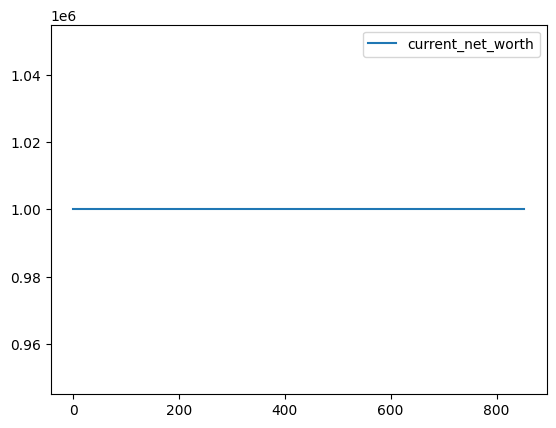

In [11]:
print(test_result_pd.tail(1).T)

test_result_pd[["current_net_worth"]].plot()

<Axes: >

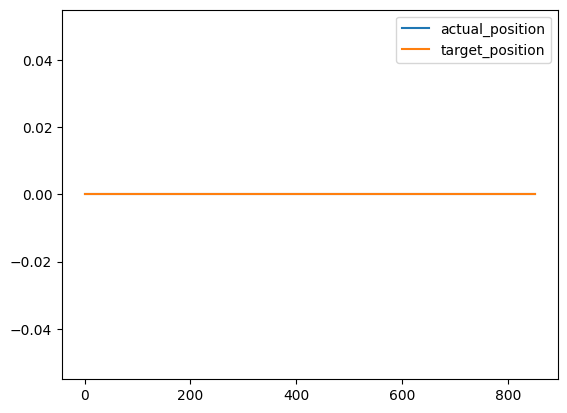

In [12]:
test_result_pd[["actual_position","target_position"]].plot()

In [12]:
train_result_pd.loc[train_result_pd["terminated"] | train_result_pd["truncated"], "episode"] = 1
train_result_pd["episode"] = train_result_pd["episode"].fillna(0)
train_result_pd["episode"] = train_result_pd["episode"].cumsum()

D:\pyvenv\rl\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


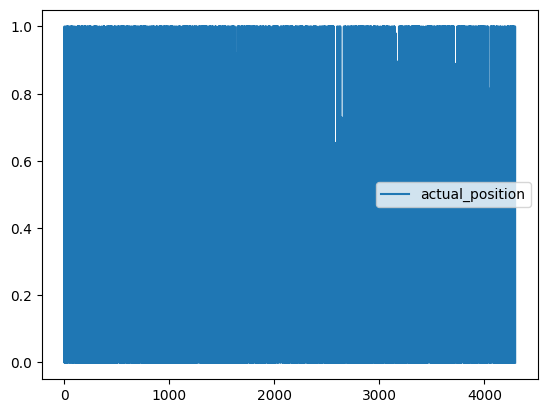

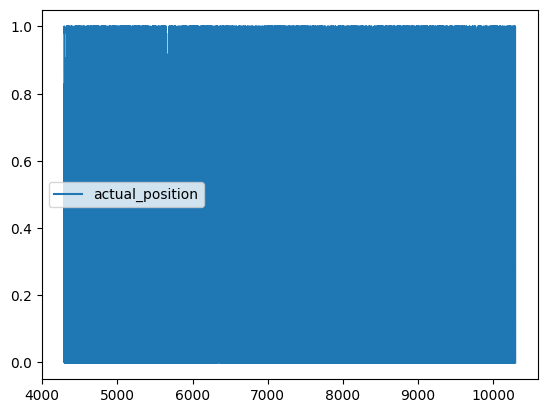

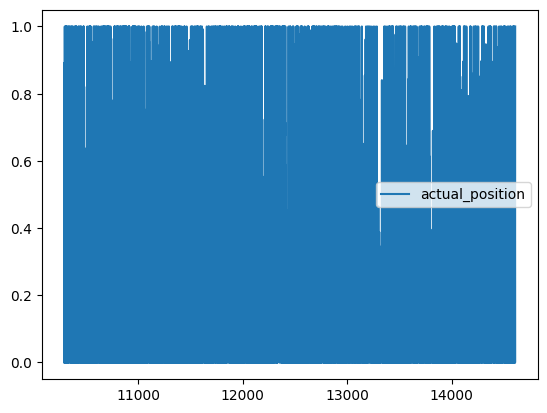

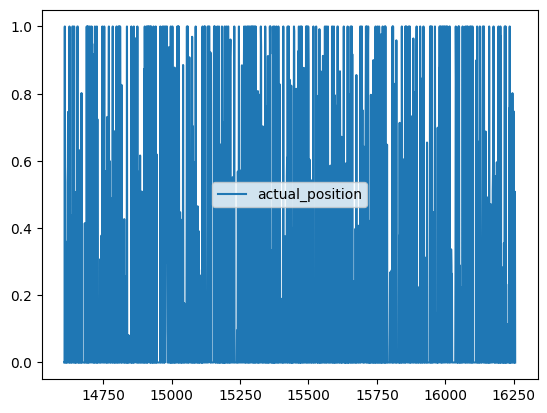

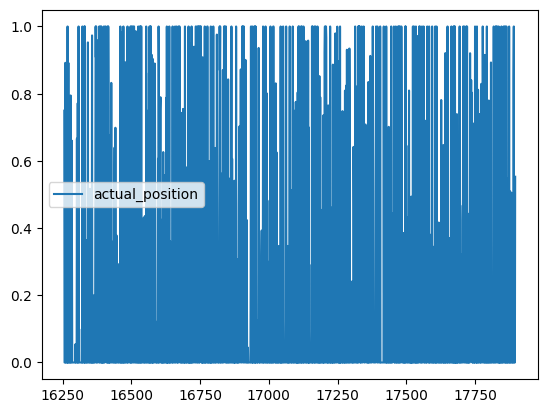

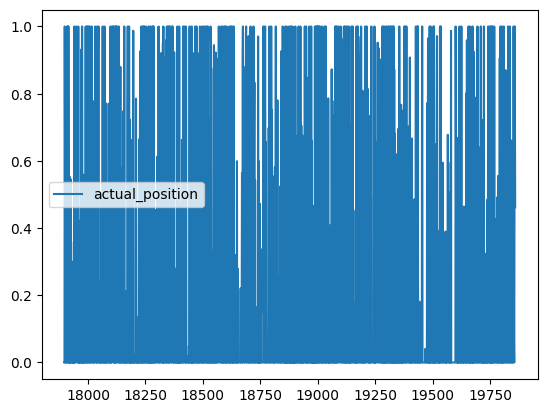

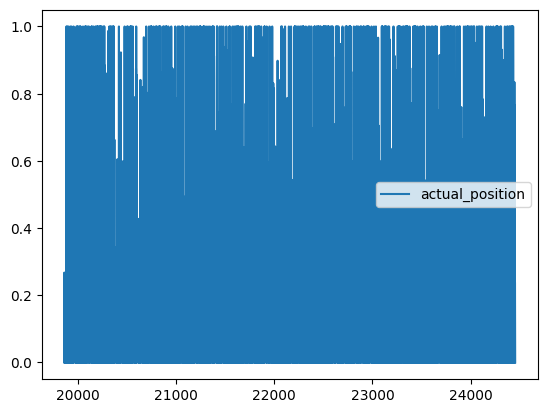

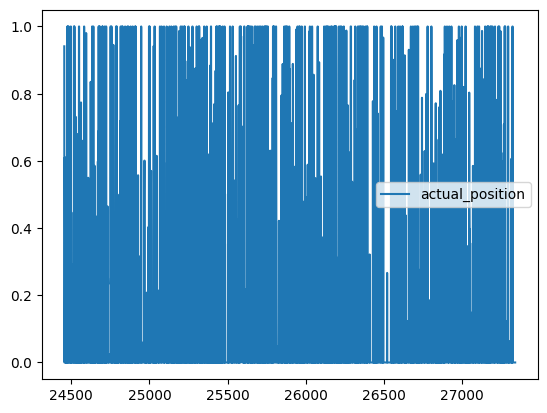

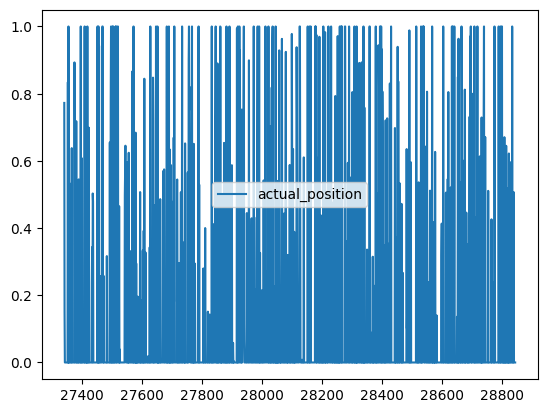

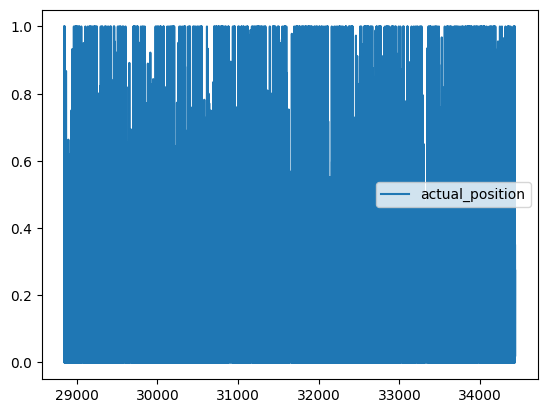

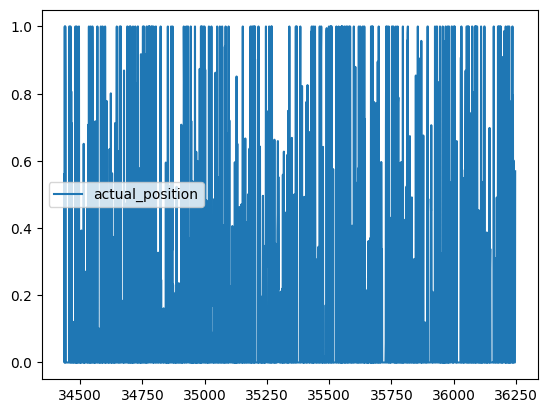

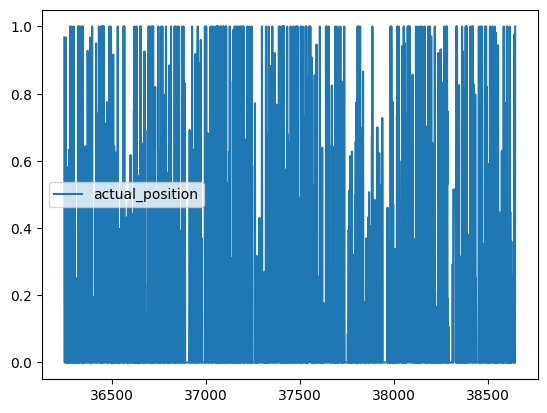

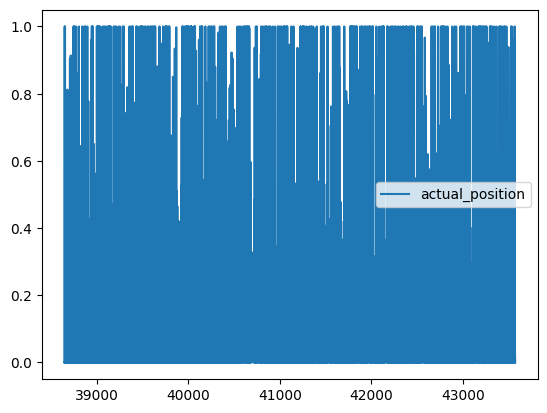

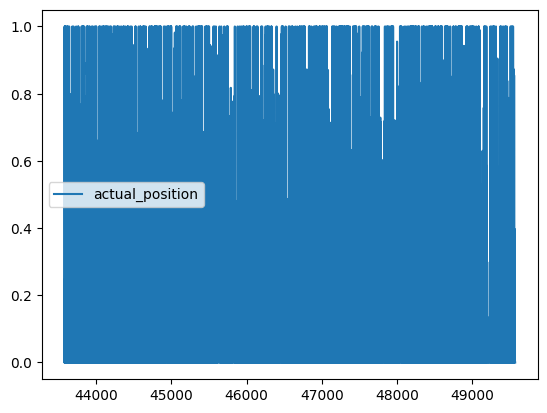

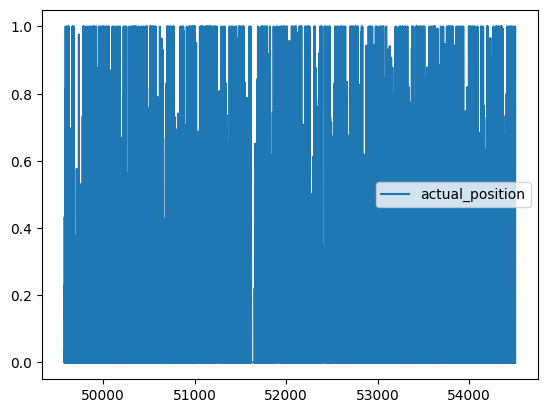

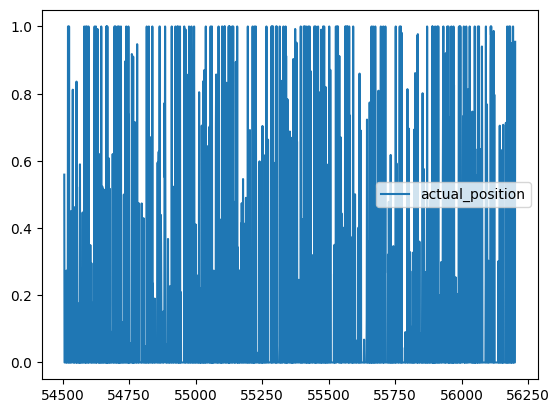

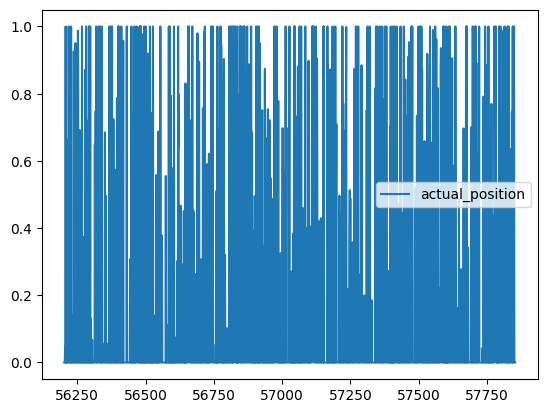

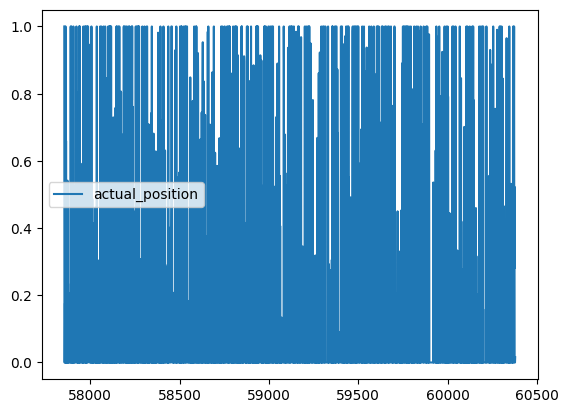

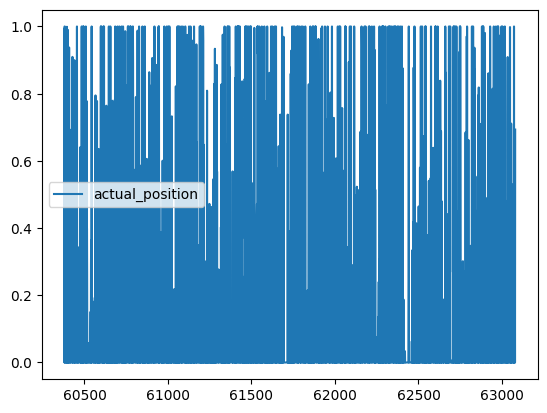

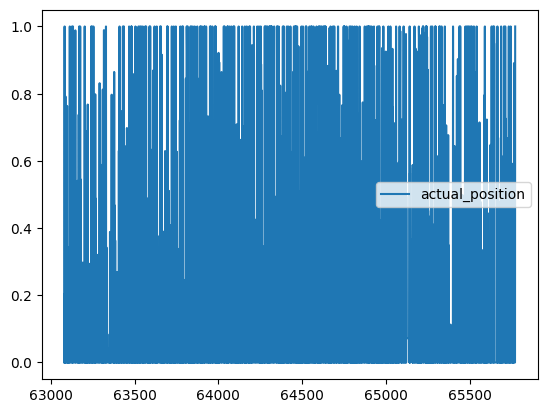

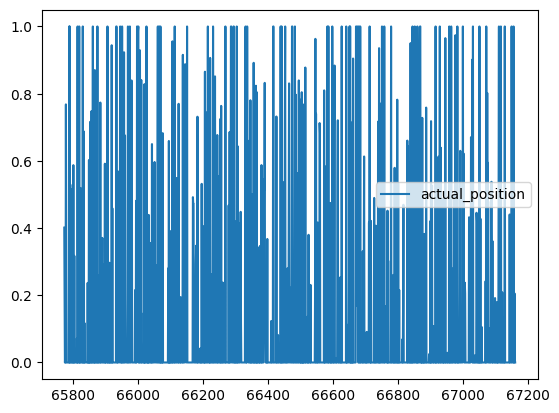

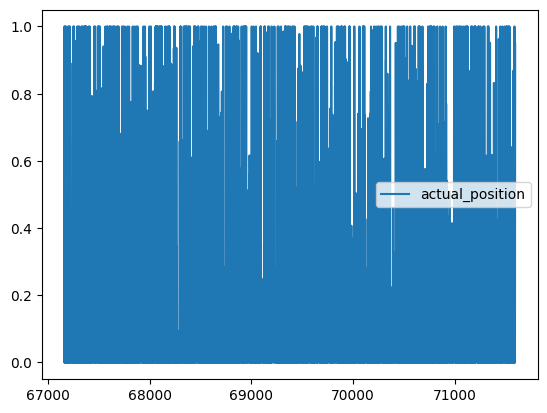

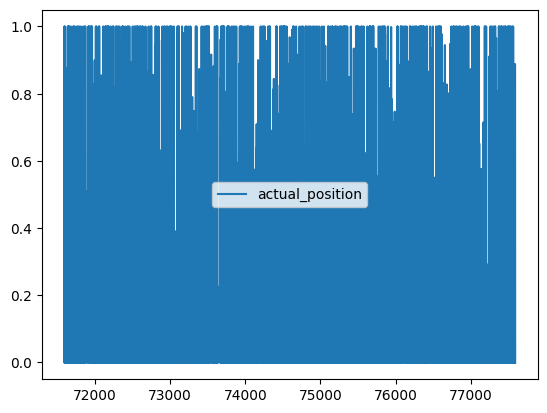

In [13]:
for i in range(23):
    train_result_pd[train_result_pd["episode"]==i][["actual_position"]].plot()